#### โครงข่ายประสาทเทียมและการเรียนรู้เชิงลึก (Artificial Neural Networks and Deep Learning)
**ดร.วโรดม ตู้จินดา**
<br>ภาควิชาวิศวกรรมเครื่องกล มหาวิทยาลัยเกษตรศาสตร์

***
## บทที่ 4 โครงข่ายประสาทเทียมเชิงสังวัตนาการ

จากบทที่ผ่านมาเราได้ศึกษาโมเดล DNN ขั้นพื้นฐาน หรือที่เรียกกันอีกชื่อหนึ่งว่า MLP (multi-layer perceptron) 
ที่ใช้งานได้ดีในปัญหาการเรียนรู้เชิงลึกโดยทั่วไป แต่จากตัวอย่างที่เกี่ยวข้องกับการประมวลผลภาพ 
กลับพบว่าได้ความแม่นยำค่อนข้างต่ำถึงแม้ว่าจะปรับปรุงโมเดลโดยวิธีการในบทที่ 3 แล้วก็ตาม 
สาเหตุสำคัญคือการเรียนรู้โดย DNN ส่วนรับอินพุตจะแปลงพิกเซลของภาพเป็นเวกเตอร์ราบ (flatten) 
โดยไม่ได้ใช้ประโยชน์จากข้อมูลเชิงพื้นที่ (spatial) ซึ่งเป็นองค์ประกอบสำคัญของภาพที่ต้องการประมวลผล 
เราสามารถทดลองได้โดยเรียงพิกเซลในแต่ละภาพใหม่แบบสุ่มก่อนทำการฝึก 
ความแม่นยำที่ได้จากโมเดลจะไม่แตกต่างจากเดิมแม้ว่าในสายตามนุษย์ไม่สามารถจำแนกได้แล้วว่าเป็นภาพอะไร

สถาปัตยกรรมของโครงข่ายประสาทเทียมเชิงลึกที่จะศึกษาในบทนี้มีชื่อเรียกว่า โครงข่ายประสาทเทียมเชิงสังวัตนาการ
(convolutional neural network) มีชื่อย่อว่า CNN 
เป็นการผสมผสานวิธีการประมวลผลภาพโดยคอมพิวเตอร์ที่ใช้งานอย่างแพร่หลายก่อนหน้าที่จะมีการพัฒนาการเรียนรู้เชิงลึก 
เพื่อดึงลักษณะเด่นเชิงพื้นที่ของภาพ เช่นการตรวจจับขอบของวัตถุในภาพ เมื่อนำการสังวัตนาการมาสร้างเป็นชั้นด้านอินพุตของโมเดลที่มีพารามิเตอร์การเรียนรู้ 
พบว่าสามารถได้ความแม่นยำในการจำแนกภาพที่สูงกว่า DNN อย่างมาก จนในปัจจุบันการเรียนรู้เชิงลึกด้านภาพจะใช้ 
CNN เป็นหลัก

นำเข้าไลบรารีของไพธอนที่ใช้ในบทนี้

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal,misc, ndimage

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

### 4.1 การสังวัตนาการสองมิติ

พื้นฐานของข้อมูลภาพที่เป็นเฉดสีเทาจะเป็น 2 มิติในรูปของเมทริกซ์ โดยค่าของแต่ละสมาชิกคือความเข้มแสงของแต่ละพิกเซล 
ในกรณีภาพสี วิธีการหนึ่งคือแยกเก็บค่าองค์ประกอบของแม่สีของแต่ละพิกเซล คือ แดง เขียว น้ำเงิน เรียกโดยย่อว่า RGB 
ดังนั้นข้อมูลภาพสีจะเป็นเทนเซอร์ 3 มิติ การดำเนินการสังวัตนาการกับภาพจะกระทำเชิงพื้นที่ คือกวาดตัวกรอง (filter) หรือเคอร์เนล (kernel) 
ที่เป็นเมทริกซ์ขนาดที่กำหนด เช่น 3x3 ไปในทิศทางตลอดความกว้างและความสูงภาพ เรียกว่าการสังวัตนาการสองมิติ (2D convolution) แบบดีสครีต 
สมการในกรณีทั่วไปคือ

$$
y[m,n] = x[m,n]*h[m,n] = \sum_j \sum_i x[i,j] h[m-i,n-j] \tag{4.1}
$$

สังเกตว่าในหนังสือทั่วไปจะใช้เครื่องหมาย \* แทนตัวดำเนินการสังวัตนาการ ซึ่งซ้ำซ้อนกับเครื่องหมายสำหรับการคูณ 
ดังนั้นต้องแยกแยะจากบริบทของเนื้อหา 

เพพื่อให้เห็นเป็นรูปธรรม รูปที่ 4.1 แสดงการคำนวณสังวัตนาการด้วยมือสำหรับเมทริกซ์อินพุตขนาด $6 \times 6$ กับเคอร์เนลขนาด $3 \times 3$ โดยไม่มีการเสริมเต็ม 
(padding) ซึ่งจะทำให้ได้เอาต์พุตเป็นเมทริกซ์ขนาดเล็กลง การหาค่าแต่ละสมาชิกของเอาต์พุตทำได้โดยเลื่อนเคอร์เนลไปที่ตำแหน่งนั้น 
คูณแต่ละสมาชิกของอินพุตกับเคอร์เนลและรวมเข้าด้วยกัน รูปที่ 4.2 แสดงตัวอย่างการคำนวณสำหรับสมาชิก $y(1,1)$ และ $y(3,4)$ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1rp8dK7IsUgnpfzIkC0p-GEGHiYPFPB-I" width=550 />
</p>
<div align="center">รูปที่ 4.1 ตัวอย่างการคำนวณสังวัตนาการ 2 มิติ</div>

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1tUre5M2T8EstkMiLFoiOIPlHRanvX6CS" width=550 />
</p>
<div align="center">รูปที่ 4.2 รายละเอียดการคำนวณสังวัตนาการ 2 มิติ</div>

**หมายเหตุ :** สังเกตว่าการดำเนินการในรูปจะไม่มีการผันกลับเคอร์เนลตาม (4.1) ซึ่งชื่อเรียกทางคณิตศาสตร์ที่ถูกต้องคือ 
การสหสัมพันธ์ไขว้ (cross-correlation) 
อย่างไรก็ตามการดำเนินการนี้สำหรับการเรียนรู้เชิงลึกถูกเรียกว่าการสังวัตนาการอย่างแพร่หลาย
    
ในการคำนวณโดยคอมพิวเตอร์เราอาจเขียนโค้ดเองหรือใช้ไลบรารีสนับสนุนซึ่งมีหลายตัว ตัวอย่างเช่น scipy.signal จะมีฟังก์ชัน convolve2d() 
สร้างเมทริกซ์อินพุตและเคอร์เนลในรูปที่ 4.1 

In [19]:
x = np.array([[4,2,9,4,7,1],
             [3,1,5,3,2,5],
             [8,7,1,2,6,2],
             [6,3,0,1,8,1],
             [1,4,1,5,7,8],
             [2,0,9,1,3,9]])
h = np.array([[1,0,-1],
             [1,0,-1],
             [1,0,-1]])

ขั้นตอนวิธีที่อิมพลิเมนต์ในฟังก์ชัน convolve2d() จะสอดคล้องกับสมการ (4.1) ดังนั้นเพื่อให้ได้เอาต์พุตตรงกับที่แสดงในรูปที่ 4.1 
เราจึงผันกลับเคอร์เนลก่อนโดยคำสั่ง

In [20]:
h = h[::-1,::-1]

ใส่เมทริกซ์ทั้งสองเป็นอาร์กิวเมนต์ของ convolve2d() โดยเลือก mode='valid' หมายความว่าไม่มีการเสริมเต็ม จะได้เอาต์พุตเท่ากับที่แสดงในรูปที่ 4.1

In [5]:
signal.convolve2d(x,h,mode='valid')

array([[  0,   1,   0,   1],
       [ 11,   5, -10,  -2],
       [ 13,   6, -19,  -3],
       [ -1,   0,  -8, -11]])

เคอร์เนลในรูปที่ 4.1 เป็นตัวอย่างหนึ่งที่นิยมใช้ในการตรวจจับขอบด้านแนวตั้ง (vertical) ของวัตถุ สมมุติว่ามีส่วนของภาพเป็นเมทริกซ์อินพุตดังนี้ 

In [6]:
x1 = np.array([[20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0]])

ซึ่งจะเห็นว่าค่าของสมาชิกด้านซ้ายคือ 20 มีค่าความสว่างมากกว่าด้านขวาคือ 0 ดังนั้นบริเวณส่วนกลางของเมทริกซ์จะเป็นขอบด้านแนวตั้ง 
เมื่อดำเนินการสังวัตนาการกับเคอร์เนล $h$ 

In [7]:
signal.convolve2d(x1,h,mode='valid')

array([[ 0, 60, 60,  0],
       [ 0, 60, 60,  0],
       [ 0, 60, 60,  0],
       [ 0, 60, 60,  0]])

จะเห็นว่าคอลัมน์บริเวณส่วนกลางของเมทริกซ์เอาต์พุตจะมีค่าสูง หากแสดงเป็นภาพจะเห็นเป็นเส้นขอบแนวตั้งที่มีความสว่าง 

##### ตัวอย่าง 4.1

เราสามารถทดสอบการตรวจจับขอบภาพโดยเคอร์เนลนี้ได้กับภาพจริง โดยอาจจะใช้ภาพของผู้อ่านเองก็ได้ 
ในตัวอย่างนี้จะใช้ภาพจาก scipy.misc เป็นภาพบันไดที่มีองค์ประกอบเป็นขอบแนวตั้งอย่างเด่นชัดคือราวบันได 
โหลดภาพเข้าสู่เมทริกซ์อินพุตและแสดงภาพได้ดังรูปที่ 4.3

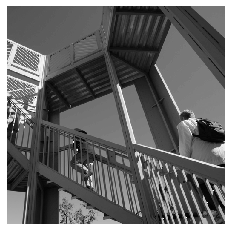

In [8]:
ascent = misc.ascent()
plt.imshow(ascent, cmap='gray')
plt.axis('off')
plt.show()

รูปที่ 4.3 ภาพบันไดจากไลบรารี scipy.misc

ตรวจจับขอบแนวตั้งโดยสังวัตนาการกับเคอร์เนล $h$ การกำหนด mode='same' จะได้เอาต์พุตเป็นเมทริกซ์ขนาดเท่ากับอินพุต 
แสดงภาพเอาต์พุตได้ดังรูปที่ 4.4

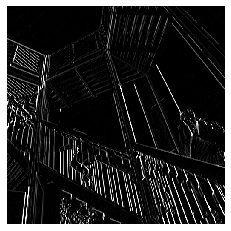

In [21]:
ascent_vertedge = signal.convolve2d(ascent,h,mode='same')
plt.imshow(ascent_vertedge, cmap='gray',vmin=0,vmax=255)
plt.axis('off')
plt.show()

รูปที่ 4.4 ผลจากการตรวจจับขอบของภาพบันไดในรูปที่ 4.3

#### 4.1.1 การเสริมเต็มเมทริกซ์อินพุต

เราสามารถกำหนดตัวเลือกบางตัวในการดำเนินการสังวัตนาการเพื่อได้เอาต์พุตที่แตกต่างออกไป 
ตัวเลือกแรกที่ได้กล่าวถึงแล้วคือ mode ทำหน้าที่กำหนดการเสริมเต็มที่บริเวณขอบของเมทริกซ์อินพุต 
กรณีไม่มีการเสริมเต็มคือเลือก mode='valid' (ตัวอย่างดังในรูปที่ 4.1) เมทริกซ์อินพุตขนาด $n \times n$ 
เมื่อสังวัตนาการกับเคอร์เนลขนาด $f \times f$ จะได้เอาต์พุตเป็นเมทริกซ์ขนาด $(n-f+1) \times (n-f+1)$ 
ข้อเสียแรกคือในทุกครั้งที่มีการทำสังวัตนาการ เอาต์พุตจะมีขนาดเล็กลงกว่าเดิม ดังนั้นหากโมเดลมีชั้นสังวัตนาการจำนวนมาก 
ภาพจะถูกลดขนาดลงจนอาจมีขนาดเล็กเกินไป ข้อเสียที่สองคือพิกเซลที่อยู่บริเวณขอบจะถูกใช้ประมวลผลน้อยกว่าส่วนกลางภาพ 
ทำให้ข้อมูลบริเวณขอบภาพอาจถูกละทิ้งไป

ทางแก้คือกำหนด mode = 'same' มีผลให้เอาต์พุตจากการสังวัตนาการมีขนาดเท่ากับอินพุต 
หลักการคือเสริมบริเวณขอบทั้งสี่ด้านของเมทริกซ์อินพุตด้วยสมาชิกค่าคงที่ (นิยมใช้ค่าศูนย์) จากตัวอย่างในรูปที่ 
4.1 หากเสริมเต็มเมทริกซ์อินพุตเป็นขนาด $8 \times 8$ ด้วยขยายขอบออกไปทั้งสี่ด้าน จะได้เมทริกซ์เอาต์พุตขนาด 
$6 \times 6$ เท่ากับขนาดอินพุตก่อนการเสริมเต็ม ในกรณีทั่วไปเมื่อเลือกจำนวนพิกเซลเสริมเต็มในแต่ละด้านของอินพุตเท่ากับ $p$ 
จะทำให้ขนาดเมทริกซ์อินพุตขยายเป็น $(n+2p) \times (n+2p)$ และขนาดเมทริกซ์เอาต์พุตเท่ากับ 
$(n+2p-f+1) \times (n+2p-f+1)$
ดังนั้นเราสามารถหาค่าของ $p$ ที่ทำให้เอาต์พุตมีขนาดเท่ากับอินพุตเดิมคือ $n \times n$ ได้คือ $p = (f-1)/2$ 
ปกตินิยมเลือกขนาดของเคอร์เนล $f$ เป็นเลขคี่ ทำให้ค่าเสริมเต็ม $p$ เป็นเลขจำนวนเต็ม 
ซึ่งในไลบรารีทั่วไปที่ใช้งานง่ายเช่น scipy หรือ TF เมื่อกำหนด mode='same' จะคำนวณค่า $p$ และเสริมเต็มให้โดยอัตโนมัติ

#### 4.1.2 การกำหนดช่วงก้าว

อีกตัวเลือกหนึ่งที่สามารถกำหนดได้ในการดำเนินการสังวัตนาการระหว่างเมทริกซ์อินพุตกับเคอร์เนลเรียกว่า ช่วงก้าว (stride) 
ซึ่งเป็นตัวกำหนดระยะ (จำนวนพิกเซล) ในการเลื่อนเคอร์เนลแต่ละครั้งทางแนวนอนและแนวตั้ง จากตัวอย่างในรูปที่ 4.1 
หากกำหนดช่วงก้าวเป็น $2$ ทั้งแนวนอนและแนวตั้ง เคอร์เนลจะถูกกวาดในลักษณะก้าวข้ามหนึ่งพิกเซล 
ผลคือเมทริกซ์เอาต์พุตจะมีขนาด $4 \times 4$ โดยตัดแถว $2,4$ และคอลัมน์ $2,4$ ของเมทริกซ์เอาต์พุตในรูปออกไป 

ในกรณีทั่วไป สำหรับเมทริกซ์อินพุตขนาด $n \times n$ และมีการเสริมเต็ม $p$ เคอร์เนลขนาด $f \times f$
เมื่อเลือกช่วงก้าว $s$ 
ทั้งแนวนอนและแนวตั้ง จะได้เอาต์พุตมีขนาด $m \times m$ โดย $m = floor((n+2p-f)/s + 1)$ 

**หมายเหตุ :** ฟังก์ชันพื้นหรือ $floor(x)$ แทนเลขจำนวนเต็มมากที่สุดที่ไม่มากไปกว่า $x$ 
    
### 4.2 การสังวัตนาการ 3 มิติ

เราสามารถขยายการดำเนินการสังวัตนาการใน 2 มิติไปยังมิติที่สูงขึ้น ตัวอย่างในรูปที่ 4.5 เมื่ออินพุตเป็นภาพสีแทนด้วยองค์ประกอบสีแดง
เขียว น้ำเงิน ดังนั้นข้อมูลภาพจะเป็นเทนเซอร์อินพุตขนาด $n_h \times n_w \times n_c$ 
โดย $n_h, n_w, n_c$ แทนจำนวนพิกเซลด้านความสูง ความกว้าง และจำนวนช่อง ตามลำดับ ส่วนเคอร์เนลเป็นเทนเซอร์ขนาด 
$f \times f \times n_c$ โดย $f$ คือขนาดของฟิลเตอร์และ $n_c$ คือจำนวนช่องที่จะต้องเท่ากับจำนวนช่องของอินพุต 
กรณีไม่มีการเสริมเต็ม เอาต์พุตจะเป็นเมทริกซ์ขนาด $(n_h-f+1) \times (n_w-f+1)$ จากตัวอย่างด้านบนของรูปที่ 4.5 
แสดงขนาดเทนเซอร์อินพุต เคอร์เนล และเอาต์พุตเท่ากับ $6 \times 6 \times 3$, $3 \times 3 \times 3$ และ 
$4 \times 4 \times 1$ ตามลำดับ โดยแต่ละสมาชิกของเอาต์พุตคำนวณได้จากการคูณแต่ละสมาชิกของอินพุตกับเคอร์เนล 
ณ ตำแหน่งนั้น (รวมการดำเนินการคูณ 27 ครั้ง) แล้วรวมค่าเข้าด้วยกัน โดยวิธีการนี้เพิ่มความยืดหยุ่นในการประมวลผลภาพมากขึ้น 
เช่นตรวจจับขอบเฉพาะองค์ประกอบสีแดงของภาพ เป็นต้น

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1DzyiySSqnMLIPtlrRil3LKBZBT5of55S" width=550 />
</p>
<div align="center">รูปที่ 4.5 ตัวอย่างการสังวัตนาการ 3 มิติ</div>

จากตัวอย่างด้านบนของรูปที่ 4.5 สามารถขยายเป็นกรณีใช้เคอร์เนลหลายชุด ดังเช่นภาพด้านล่างแสดงการใช้เคอร์เนล 2 ชุด 
ทำให้ได้เอาต์พุตจากการสังวัตนาการเป็นเทนเซอร์ขนาด $4 \times 4 \times 2$ 
สำหรับกรณีทั่วไปขนาดของเทนเซอร์เอาต์พุตจะเท่ากับ $(n_h-f+1) \times (n_w-f+1) \times n_f$ 
โดย $n_f$ คือจำนวนชุดของเคอร์เนล หากมีการกำหนดค่าเสริมเต็มและช่วงก้าว 
จะได้เอาต์พุตมีขนาด $floor((n_h+2p-f)/s + 1) \times floor((n_w+2p-f)/s + 1) \times n_f$ 

### โจทย์ปัญหา 

4-1 การประมวลผลภาพโดยวิธีสังวัตนาการสามารถทำได้มากกว่าการตรวจจับขอบ ทดลองเปลี่ยนเคอร์เนลในตัวอย่าง 4.1 
เป็น 2 ตัวอย่างดังนี้

In [10]:
h = np.array([[0,-1,0],
             [-1,5,-1],
             [0,-1,0]])

In [17]:
h = (1/9)*np.array([[1,1,1],
             [1,1,1],
             [1,1,1]])

จะได้ภาพเอาต์พุตเปลี่ยนไปอย่างไร? 

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>